# Terrain Reconstruction from Occluded Voids using Point Cloud
This notebook processes ground-filtered LiDAR point cloud data to reconstruct occluded terrain using:

- Iterative plane fitting
- Jittered sample generation
- Spline and PDE smoothing
- RMSE comparison across 8 reconstruction strategies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import laspy

from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
from scipy.sparse import lil_matrix, diags
from scipy.sparse.linalg import spsolve
from scipy.spatial import cKDTree
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import os
import time

In [3]:
# Load the LAZ file
file_path = "../data/S7_1.laz"
las = laspy.read(file_path, laz_backend=laspy.LazBackend.Lazrs)
points = pd.DataFrame({
    "x": np.array(las.x),
    "y": np.array(las.y),
    "z": np.array(las.z),
    "classification": np.array(las.classification)
})
ground = points[points["classification"] == 2].copy().reset_index(drop=True)


In [4]:
def generate_voids(data, count=3, width=2.0, height=5.0, x_offset=10, y_offset=10):
    voids = []
    for i in range(count):
        x0 = data["x"].min() + x_offset + i * (width + 3)
        y0 = data["y"].min() + y_offset
        voids.append({
            "x0": x0,
            "x1": x0 + width,
            "y0": y0,
            "y1": y0 + height
        })
    return voids

voids = generate_voids(ground, count=3)


In [5]:
def pde_smooth(x, y, alpha=1e-2):
    n = len(x)
    dx = np.mean(np.diff(x))
    L = lil_matrix((n, n))
    for i in range(n):
        if i >= 2: L[i, i-2] = 1
        if i >= 1: L[i, i-1] = -4
        L[i, i] = 6
        if i <= n - 2: L[i, i+1] = -4
        if i <= n - 3: L[i, i+2] = 1
    L[0, :] = L[1, :] = L[-1, :] = L[-2, :] = 0
    L = L.tocsc()
    A = diags([1], [0], shape=(n, n)).tocsc() + alpha * (L / dx**4)
    return spsolve(A, y)


In [6]:
def fit_plane_and_extend(pts, axis="x", direction=1, extent=1.0, sample_count=4):
    if len(pts) < 3:
        return pd.DataFrame(columns=["x", "y", "z"])
    model = LinearRegression()
    X = pts[["x", "y"]].values
    z = pts["z"].values
    model.fit(X, z)
    if axis == "x":
        start = pts["x"].max() if direction > 0 else pts["x"].min() - extent
        x_vals = np.linspace(start, start + direction * extent, sample_count)
        y_vals = np.full_like(x_vals, pts["y"].mean())
    else:
        start = pts["y"].max() if direction > 0 else pts["y"].min() - extent
        y_vals = np.linspace(start, start + direction * extent, sample_count)
        x_vals = np.full_like(y_vals, pts["x"].mean())
    coords = np.column_stack((x_vals, y_vals))
    z_vals = model.predict(coords)
    w = np.linspace(0, 1, sample_count)
    jitter = (w ** 2) * 0.2
    z_jittered = z_vals + np.where(z_vals < pts["z"].mean(), jitter, -jitter)
    return pd.DataFrame(list(zip(x_vals, y_vals, z_jittered)), columns=["x", "y", "z"])


In [7]:
def compute_rmse(surface_x, surface_y, surface_z, truth_pts):
    surface_points = np.column_stack((surface_x, surface_y))
    truth_points = np.column_stack((truth_pts["x"].values, truth_pts["y"].values))
    tree = cKDTree(surface_points)
    dists, idx = tree.query(truth_points)
    pred_z = np.array(surface_z)[idx]
    return np.sqrt(np.mean((pred_z - truth_pts["z"].values) ** 2))


In [8]:
def generate_random_voids(data, count=3, width=2.0, height=5.0, buffer=1.5):
    voids = []
    x_min, x_max = data["x"].min() + buffer + width, data["x"].max() - buffer - width
    y_min, y_max = data["y"].min() + buffer + height, data["y"].max() - buffer - height
    for _ in range(count):
        x0 = random.uniform(x_min, x_max - width)
        y0 = random.uniform(y_min, y_max - height)
        voids.append({
            "x0": x0, "x1": x0 + width,
            "y0": y0, "y1": y0 + height
        })
    return voids


In [11]:
voids = generate_random_voids(ground, count=30)

# To replicate the results presented in the paper using exact same voids, refer to "../Data/20250528_30x_voids.csv"

In [12]:
voids

[{'x0': np.float64(276842.9794470279),
  'x1': np.float64(276844.9794470279),
  'y0': np.float64(4868852.392447831),
  'y1': np.float64(4868857.392447831)},
 {'x0': np.float64(276617.12848732877),
  'x1': np.float64(276619.12848732877),
  'y0': np.float64(4868685.674059852),
  'y1': np.float64(4868690.674059852)},
 {'x0': np.float64(276934.0172061772),
  'x1': np.float64(276936.0172061772),
  'y0': np.float64(4868505.3957873145),
  'y1': np.float64(4868510.3957873145)},
 {'x0': np.float64(276905.6996165992),
  'x1': np.float64(276907.6996165992),
  'y0': np.float64(4868571.597289722),
  'y1': np.float64(4868576.597289722)},
 {'x0': np.float64(276839.45595805475),
  'x1': np.float64(276841.45595805475),
  'y0': np.float64(4868865.131634588),
  'y1': np.float64(4868870.131634588)},
 {'x0': np.float64(276785.6930835572),
  'x1': np.float64(276787.6930835572),
  'y0': np.float64(4868689.242952223),
  'y1': np.float64(4868694.242952223)},
 {'x0': np.float64(276588.66973810893),
  'x1': np.f

### Run All 8 Reconstruction Variants

In [13]:
results = []
axes = [("x", 2.0), ("y", 5.0)]
modes = ["mid", "full"]
methods = ["spline", "pde"]

counter = 0

for void in voids:
    counter = counter + 1
    print("\n")
    print(f"Void Number: {counter}")
    print("\n")
    
    in_void = (
        (ground["x"] >= void["x0"]) & (ground["x"] <= void["x1"]) &
        (ground["y"] >= void["y0"]) & (ground["y"] <= void["y1"])
    )
    interior = ground[in_void].copy()
    exterior = ground[~in_void].copy()

    for axis_name, size in axes:
        for mode in modes:
            for interp in methods:
                axis0 = f"{axis_name}0"
                lower_bound = void[axis0] - 1.5
                upper_bound = void[axis0]

                mask = (exterior[axis_name] >= lower_bound) & (exterior[axis_name] <= upper_bound)
                pts = exterior[mask].copy()

                if pts.empty:
                    print(f"Skipping: No exterior points found for {axis_name.upper()} side.")
                    continue

                fwd = fit_plane_and_extend(pts, axis_name, 1, 1.5)
                bwd = fit_plane_and_extend(pts, axis_name, -1, 1.5)

                if fwd.empty or bwd.empty:
                    print(f"Skipping: No samples generated for {axis_name.upper()} {mode} {interp}")
                    continue

                if mode == "full":
                    samples = pd.concat([fwd, bwd], ignore_index=True)
                else:
                    midpoint = fwd[axis_name].mean()
                    forward_half = fwd[fwd[axis_name] <= midpoint]
                    backward_half = bwd[bwd[axis_name] >= midpoint]
                    samples = pd.concat([forward_half, backward_half], ignore_index=True)

                samples = samples.sort_values(by=axis_name)
                x_vals = samples[axis_name].values
                z_vals = samples["z"].values

                if interp == "spline":
                    from scipy.interpolate import CubicSpline
                    cs = CubicSpline(x_vals, z_vals)
                    x_dense = np.linspace(x_vals.min(), x_vals.max(), 200)
                    z_dense = cs(x_dense)
                else:
                    z_dense = pde_smooth(x_vals, z_vals)
                    x_dense = x_vals

                y_dense = np.full_like(x_dense, samples["y"].mean()) if axis_name == "x" else np.full_like(x_dense, samples["x"].mean())
                rmse = compute_rmse(x_dense, y_dense, z_dense, interior)
                label = f"{mode.upper()} | {axis_name.upper()} | {interp.upper()}"
                results.append((label, rmse))
                print(f"{label:<25} → RMSE: {rmse:.4f}")




Void Number: 1


MID | X | SPLINE          → RMSE: 11.1753
MID | X | PDE             → RMSE: 11.1888
FULL | X | SPLINE         → RMSE: 10.9222
FULL | X | PDE            → RMSE: 10.9712
MID | Y | SPLINE          → RMSE: 27.0446
MID | Y | PDE             → RMSE: 27.0446
FULL | Y | SPLINE         → RMSE: 27.1803
FULL | Y | PDE            → RMSE: 27.1803


Void Number: 2


MID | X | SPLINE          → RMSE: 10.4479
MID | X | PDE             → RMSE: 10.4479
FULL | X | SPLINE         → RMSE: 10.5034
FULL | X | PDE            → RMSE: 10.5019
MID | Y | SPLINE          → RMSE: 17.0628
MID | Y | PDE             → RMSE: 17.0628
FULL | Y | SPLINE         → RMSE: 16.5680
FULL | Y | PDE            → RMSE: 16.5680


Void Number: 3


MID | X | SPLINE          → RMSE: 3.8947
MID | X | PDE             → RMSE: 3.8897
FULL | X | SPLINE         → RMSE: 3.8786
FULL | X | PDE            → RMSE: 3.8725
MID | Y | SPLINE          → RMSE: 23.6096
MID | Y | PDE             → RMSE: 23.6096
FULL | Y | SPLINE      

$Next:$ analysing the voids.<br>
Whether there is statistically significant differences between the 8 variants?<br>
When shorter side rendered more accurate results and when longer side?<br>

In [115]:
results[:5]
# first five samples

[('MID | X | SPLINE', np.float64(11.175288201799859)),
 ('MID | X | PDE', np.float64(11.188807880581495)),
 ('FULL | X | SPLINE', np.float64(10.922241562007796)),
 ('FULL | X | PDE', np.float64(10.97116688570725)),
 ('MID | Y | SPLINE', np.float64(27.044647209766417))]

In [69]:
len(results)

240

In [14]:
methods = [
    "MID | X | SPLINE", "MID | X | PDE",
    "FULL | X | SPLINE", "FULL | X | PDE",
    "MID | Y | SPLINE", "MID | Y | PDE",
    "FULL | Y | SPLINE", "FULL | Y | PDE"
]

In [67]:
len(rmse_values)

30

In [76]:
results

[('MID | X | SPLINE', np.float64(11.175288201799859)),
 ('MID | X | PDE', np.float64(11.188807880581495)),
 ('FULL | X | SPLINE', np.float64(10.922241562007796)),
 ('FULL | X | PDE', np.float64(10.97116688570725)),
 ('MID | Y | SPLINE', np.float64(27.044647209766417)),
 ('MID | Y | PDE', np.float64(27.044647209766417)),
 ('FULL | Y | SPLINE', np.float64(27.18032824609476)),
 ('FULL | Y | PDE', np.float64(27.18032824609476)),
 ('MID | X | SPLINE', np.float64(10.44788864469585)),
 ('MID | X | PDE', np.float64(10.44788864469585)),
 ('FULL | X | SPLINE', np.float64(10.503376570700093)),
 ('FULL | X | PDE', np.float64(10.501949423161308)),
 ('MID | Y | SPLINE', np.float64(17.062782015464535)),
 ('MID | Y | PDE', np.float64(17.062782015464535)),
 ('FULL | Y | SPLINE', np.float64(16.56801845351403)),
 ('FULL | Y | PDE', np.float64(16.56801845351403)),
 ('MID | X | SPLINE', np.float64(3.8947001518211213)),
 ('MID | X | PDE', np.float64(3.889749672954934)),
 ('FULL | X | SPLINE', np.float64(3.8

In [114]:
len(results)
# Must be 240

240

In [97]:
# Convert into DataFrame
data_rmse_iterations = []
for i, row in enumerate(results):
    approach, axis, method = row[0].split(" | ")
    value = row[1]
    void = i+1
    group = row[0]
    data_rmse_iterations.append({
        "Void": void,
        "Approach": approach,
        "Axis": axis,
        "Method": method,
        "RMSE": value,
        "Group": group
    })

df_rmse = pd.DataFrame(data_rmse_iterations)

In [98]:
df_rmse

,Void,Approach,Axis,Method,RMSE,Group
0,1,MID,X,SPLINE,11.175288,MID | X | SPLINE
1,2,MID,X,PDE,11.188808,MID | X | PDE
2,3,FULL,X,SPLINE,10.922242,FULL | X | SPLINE
3,4,FULL,X,PDE,10.971167,FULL | X | PDE
4,5,MID,Y,SPLINE,27.044647,MID | Y | SPLINE
...,...,...,...,...,...,...
235,236,FULL,X,PDE,7.206231,FULL | X | PDE
236,237,MID,Y,SPLINE,25.393606,MID | Y | SPLINE
237,238,MID,Y,PDE,25.393606,MID | Y | PDE
238,239,FULL,Y,SPLINE,25.252332,FULL | Y | SPLINE


In [122]:
df_rmse

,Void,Approach,Axis,Method,RMSE,Group,RMSE_1st_run
0,1,MID,X,SPLINE,11.175288,MID | X | SPLINE,3.3427
1,2,MID,X,PDE,11.188808,MID | X | PDE,3.3426
2,3,FULL,X,SPLINE,10.922242,FULL | X | SPLINE,3.2704
3,4,FULL,X,PDE,10.971167,FULL | X | PDE,3.2698
4,5,MID,Y,SPLINE,27.044647,MID | Y | SPLINE,16.6930
...,...,...,...,...,...,...,...
235,236,FULL,X,PDE,7.206231,FULL | X | PDE,20.2431
236,237,MID,Y,SPLINE,25.393606,MID | Y | SPLINE,2.5582
237,238,MID,Y,PDE,25.393606,MID | Y | PDE,2.5582
238,239,FULL,Y,SPLINE,25.252332,FULL | Y | SPLINE,3.4475


In [130]:
# df_rmse.to_csv("20250530_RMSE_Runs_all_methods_both_axes.csv", index = False)

In [135]:
# Run ANOVA
model = ols('RMSE ~ C(Group)', data=df_rmse).fit()
anova_results = anova_lm(model)

In [136]:
# Run Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_rmse["RMSE"], groups=df_rmse["Group"], alpha=0.05)

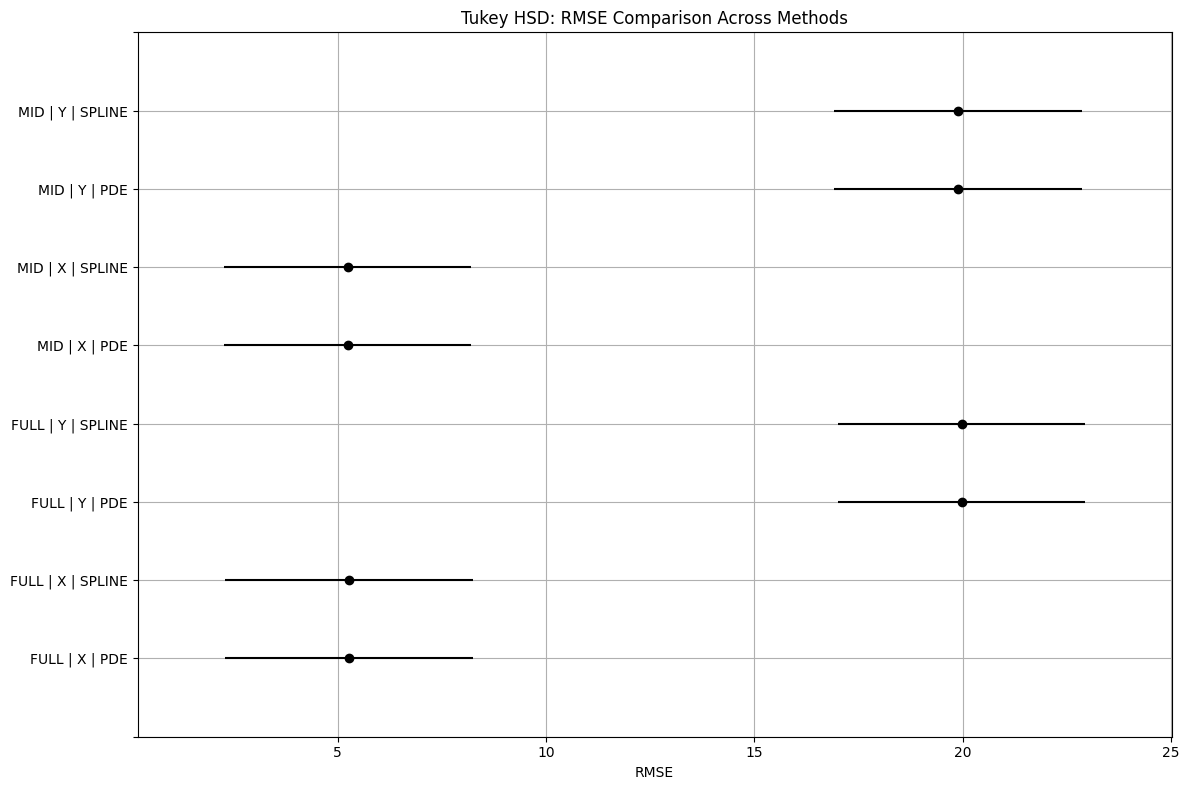

In [128]:
# Plot Tukey results
fig = tukey.plot_simultaneous(figsize=(12, 8))
plt.title("Tukey HSD: RMSE Comparison Across Methods")
plt.xlabel("RMSE")
plt.grid(True)
plt.tight_layout()

In [137]:
anova_results, tukey.summary()

(             df        sum_sq      mean_sq          F        PR(>F)
 C(Group)    7.0  12929.136770  1847.019539  32.640996  2.332137e-31
 Residual  232.0  13127.924414    56.585881        NaN           NaN,
 <class 'statsmodels.iolib.table.SimpleTable'>)

Refresher:
$$F = \frac{Variance\ between\ group\ means}{Variance\ within\ groups\ (residual)}$$
<br/>
- FWER: Family-wise Error Rate
<br/>
- Tukey’s HSD is a post-hoc test used after ANOVA when you want to know which specific groups <b>differ</b> from each other.
<br/>
- HSD was invented by "John Wilder Tukey", an American mathematician and statistician, best known for the development of the fast Fourier Transform (FFT) algorithm and box plot.

In [138]:
df_tukey_hsd = pd.DataFrame(tukey.summary().data[1:], columns = tukey.summary().data[0])

In [139]:
df_tukey_hsd.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FULL | X | PDE,FULL | X | SPLINE,-0.0009,1.0,-5.9419,5.9402,False
1,FULL | X | PDE,FULL | Y | PDE,14.7062,0.0,8.7651,20.6472,True
2,FULL | X | PDE,FULL | Y | SPLINE,14.7062,0.0,8.7651,20.6472,True
3,FULL | X | PDE,MID | X | PDE,-0.0306,1.0,-5.9716,5.9105,False
4,FULL | X | PDE,MID | X | SPLINE,-0.0301,1.0,-5.9711,5.9109,False


In [140]:
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
C(Group),7.0,12929.136770,1847.019539,32.640996,2.332137e-31
Residual,232.0,13127.924414,56.585881,NaN,NaN


In [141]:
# df_tukey_hsd.to_csv('../Data/20250530_tukey_hsd_for_accuracy.csv', index = False)
# anova_results.to_csv('../Data/20250530_anova_for_accuracy.csv', index = False)

In [105]:
df_tukey_hsd.shape

(28, 7)

In [106]:
df_tukey_hsd[df_tukey_hsd['reject'] == False]
# False in Tukey's HSD test means they are not significantly different.

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FULL | X | PDE,FULL | X | SPLINE,-0.0009,1.0,-5.9419,5.9402,False
3,FULL | X | PDE,MID | X | PDE,-0.0306,1.0,-5.9716,5.9105,False
4,FULL | X | PDE,MID | X | SPLINE,-0.0301,1.0,-5.9711,5.9109,False
9,FULL | X | SPLINE,MID | X | PDE,-0.0297,1.0,-5.9707,5.9113,False
10,FULL | X | SPLINE,MID | X | SPLINE,-0.0293,1.0,-5.9703,5.9118,False
13,FULL | Y | PDE,FULL | Y | SPLINE,0.0000,1.0,-5.9410,5.9410,False
16,FULL | Y | PDE,MID | Y | PDE,-0.0845,1.0,-6.0256,5.8565,False
17,FULL | Y | PDE,MID | Y | SPLINE,-0.0845,1.0,-6.0256,5.8565,False
20,FULL | Y | SPLINE,MID | Y | PDE,-0.0845,1.0,-6.0256,5.8565,False
21,FULL | Y | SPLINE,MID | Y | SPLINE,-0.0845,1.0,-6.0256,5.8565,False


In [107]:
len(df_tukey_hsd[df_tukey_hsd['reject'] == False])

12

In [108]:
df_tukey_hsd[df_tukey_hsd['reject'] == True]
# True in Tukey's HSD test means they are significantly different.

,group1,group2,meandiff,p-adj,lower,upper,reject
1,FULL | X | PDE,FULL | Y | PDE,14.7062,0.0,8.7651,20.6472,True
2,FULL | X | PDE,FULL | Y | SPLINE,14.7062,0.0,8.7651,20.6472,True
5,FULL | X | PDE,MID | Y | PDE,14.6216,0.0,8.6806,20.5627,True
6,FULL | X | PDE,MID | Y | SPLINE,14.6216,0.0,8.6806,20.5627,True
7,FULL | X | SPLINE,FULL | Y | PDE,14.7070,0.0,8.7660,20.6481,True
8,FULL | X | SPLINE,FULL | Y | SPLINE,14.7070,0.0,8.7660,20.6481,True
11,FULL | X | SPLINE,MID | Y | PDE,14.6225,0.0,8.6815,20.5635,True
12,FULL | X | SPLINE,MID | Y | SPLINE,14.6225,0.0,8.6815,20.5635,True
14,FULL | Y | PDE,MID | X | PDE,-14.7367,0.0,-20.6778,-8.7957,True
15,FULL | Y | PDE,MID | X | SPLINE,-14.7363,0.0,-20.6773,-8.7953,True


In [109]:
len(df_tukey_hsd[df_tukey_hsd['reject'] == True])

16

In [110]:
# Calculate mean RMSE for each method group
mean_rmse = df_rmse.groupby("Group")["RMSE"].mean().sort_values().reset_index()
mean_rmse.columns = ["Method", "Mean_RMSE"]

In [111]:
# Top performing group(s) (lowest RMSE)
top_performer = mean_rmse.iloc[0:3]

In [112]:
top_performer

,Method,Mean_RMSE
0,MID | X | PDE,5.235866
1,MID | X | SPLINE,5.236304
2,FULL | X | SPLINE,5.265566


In [113]:
mean_rmse

,Method,Mean_RMSE
0,MID | X | PDE,5.235866
1,MID | X | SPLINE,5.236304
2,FULL | X | SPLINE,5.265566
3,FULL | X | PDE,5.266427
4,MID | Y | PDE,19.888068
5,MID | Y | SPLINE,19.888068
6,FULL | Y | PDE,19.972596
7,FULL | Y | SPLINE,19.972596


### Compute Comparison

In [35]:
# Methods to benchmark and analyse
# Desired combinations (method variants to test)
selected_methods = {
    ("mid", "x", "spline"),
    ("mid", "x", "pde"),
    ("full", "x", "spline"),
    ("full", "x", "pde")
}

In [36]:
# Number of repetitions for each method to ensure statistical significance
num_runs = 10 # Simulate timing for 10 runs per method
num_voids = 30

In [37]:
dict(zip(list(range(1,31)), voids))

{1: {'x0': np.float64(276842.9794470279),
  'x1': np.float64(276844.9794470279),
  'y0': np.float64(4868852.392447831),
  'y1': np.float64(4868857.392447831)},
 2: {'x0': np.float64(276617.12848732877),
  'x1': np.float64(276619.12848732877),
  'y0': np.float64(4868685.674059852),
  'y1': np.float64(4868690.674059852)},
 3: {'x0': np.float64(276934.0172061772),
  'x1': np.float64(276936.0172061772),
  'y0': np.float64(4868505.3957873145),
  'y1': np.float64(4868510.3957873145)},
 4: {'x0': np.float64(276905.6996165992),
  'x1': np.float64(276907.6996165992),
  'y0': np.float64(4868571.597289722),
  'y1': np.float64(4868576.597289722)},
 5: {'x0': np.float64(276839.45595805475),
  'x1': np.float64(276841.45595805475),
  'y0': np.float64(4868865.131634588),
  'y1': np.float64(4868870.131634588)},
 6: {'x0': np.float64(276785.6930835572),
  'x1': np.float64(276787.6930835572),
  'y0': np.float64(4868689.242952223),
  'y1': np.float64(4868694.242952223)},
 7: {'x0': np.float64(276588.66973

In [38]:
voids_dict = dict(zip(list(range(1,31)), voids))

In [40]:
df_voids = pd.DataFrame.from_dict(voids_dict, orient='index')
# Specify orient='index' to create the DataFrame using dictionary keys as rows

In [41]:
df_voids

,x0,x1,y0,y1
1,276842.979447,276844.979447,4.868852e+06,4.868857e+06
2,276617.128487,276619.128487,4.868686e+06,4.868691e+06
3,276934.017206,276936.017206,4.868505e+06,4.868510e+06
4,276905.699617,276907.699617,4.868572e+06,4.868577e+06
5,276839.455958,276841.455958,4.868865e+06,4.868870e+06
6,276785.693084,276787.693084,4.868689e+06,4.868694e+06
7,276588.669738,276590.669738,4.868761e+06,4.868766e+06
8,276792.366136,276794.366136,4.868949e+06,4.868954e+06
9,276735.572005,276737.572005,4.868550e+06,4.868555e+06
10,276523.740479,276525.740479,4.868565e+06,4.868570e+06


In [148]:
# df_voids.to_csv("../data/20250528_30x_voids.csv", index = False)

In [42]:
timing_results = []

for run in range(num_runs):
    for label_mode, label_axis, label_interp in selected_methods:
        

        for void in voids:
            start_time = time.time()
            in_void = (
                (ground["x"] >= void["x0"]) & (ground["x"] <= void["x1"]) &
                (ground["y"] >= void["y0"]) & (ground["y"] <= void["y1"])
            )
            interior = ground[in_void].copy()
            exterior = ground[~in_void].copy()

            axis0 = f"{label_axis}0"
            lower_bound = void[axis0] - 1.5
            upper_bound = void[axis0]

            mask = (exterior[label_axis] >= lower_bound) & (exterior[label_axis] <= upper_bound)
            pts = exterior[mask].copy()

            if pts.empty:
                continue

            fwd = fit_plane_and_extend(pts, label_axis, 1, 1.5)
            bwd = fit_plane_and_extend(pts, label_axis, -1, 1.5)

            if fwd.empty or bwd.empty:
                continue

            if label_mode == "full":
                samples = pd.concat([fwd, bwd], ignore_index=True)
            else:
                midpoint = fwd[label_axis].mean()
                forward_half = fwd[fwd[label_axis] <= midpoint]
                backward_half = bwd[bwd[label_axis] >= midpoint]
                samples = pd.concat([forward_half, backward_half], ignore_index=True)

            samples = samples.sort_values(by=label_axis)
            x_vals = samples[label_axis].values
            z_vals = samples["z"].values

            if label_interp == "spline":
                cs = CubicSpline(x_vals, z_vals)
                x_dense = np.linspace(x_vals.min(), x_vals.max(), 200)
                z_dense = cs(x_dense)
            else:
                z_dense = pde_smooth(x_vals, z_vals)
                x_dense = x_vals

            y_dense = np.full_like(x_dense, samples["y"].mean()) if label_axis == "x" else np.full_like(x_dense, samples["x"].mean())
            _ = compute_rmse(x_dense, y_dense, z_dense, interior)  # RMSE is not needed for timing

            end_time = time.time()
            duration = end_time - start_time
            method_label = f"{label_mode.upper()} | {label_axis.upper()} | {label_interp.upper()}"
            timing_results.append({
                "Run": run + 1,
                "Method": method_label,
                "Time (seconds)": duration
        })

In [43]:
timing_results

[{'Run': 1, 'Method': 'FULL | X | PDE', 'Time (seconds)': 0.03163790702819824},
 {'Run': 1, 'Method': 'FULL | X | PDE', 'Time (seconds)': 0.01579594612121582},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.011473894119262695},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.010550975799560547},
 {'Run': 1, 'Method': 'FULL | X | PDE', 'Time (seconds)': 0.01064920425415039},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.008280038833618164},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.008023977279663086},
 {'Run': 1, 'Method': 'FULL | X | PDE', 'Time (seconds)': 0.00761103630065918},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.0077860355377197266},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.0076601505279541016},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.007112026214599609},
 {'Run': 1,
  'Method': 'FULL | X | PDE',
  'Time (seconds)': 0.007133960723876953}

In [142]:
len(timing_results)

1200

In [143]:
# Convert to DataFrame for further analysis
df_timing = pd.DataFrame(timing_results)

In [144]:
df_timing

,Run,Method,Time (seconds)
0,1,FULL | X | PDE,0.031638
1,1,FULL | X | PDE,0.015796
2,1,FULL | X | PDE,0.011474
3,1,FULL | X | PDE,0.010551
4,1,FULL | X | PDE,0.010649
...,...,...,...
1195,10,MID | X | PDE,0.007882
1196,10,MID | X | PDE,0.007251
1197,10,MID | X | PDE,0.007248
1198,10,MID | X | PDE,0.007966


In [145]:
df_timing['Method'].value_counts()

Method
FULL | X | PDE       300
MID | X | SPLINE     300
FULL | X | SPLINE    300
MID | X | PDE        300
Name: count, dtype: int64

In [147]:
# df_timing.to_csv("../data/20250528_selected_methods_compute_time.csv", index = False)

In [146]:
# ANOVA
anova_model = ols('Q("Time (seconds)") ~ C(Method)', data = df_timing).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

In [147]:
# Tukey's HSD
tukey_result = pairwise_tukeyhsd(endog = df_timing["Time (seconds)"],
                                 groups = df_timing["Method"],
                                 alpha = 0.05)

In [50]:
anova_table, tukey_result.summary()

(             sum_sq      df         F   PR(>F)
 C(Method)  0.000026     3.0  8.752906  0.00001
 Residual   0.001186  1196.0       NaN      NaN,
 <class 'statsmodels.iolib.table.SimpleTable'>)

This very low p-value indicates statistically significant differences in compute times across the four methods. We can reject the null hypothesis that all methods have the same mean computation time.

In [149]:
anova_table

,sum_sq,df,F,PR(>F)
C(Method),0.000026,3.0,8.752906,0.00001
Residual,0.001186,1196.0,NaN,NaN


In [150]:
tukey_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FULL | X | PDE,FULL | X | SPLINE,-0.0004,0.0,-0.0006,-0.0002,True
FULL | X | PDE,MID | X | PDE,-0.0,0.938,-0.0003,0.0002,False
FULL | X | PDE,MID | X | SPLINE,-0.0002,0.0181,-0.0004,-0.0,True
FULL | X | SPLINE,MID | X | PDE,0.0003,0.0005,0.0001,0.0005,True
FULL | X | SPLINE,MID | X | SPLINE,0.0001,0.3965,-0.0001,0.0003,False
MID | X | PDE,MID | X | SPLINE,-0.0002,0.0876,-0.0004,0.0,False


In [151]:
df_tukey_hsd.to_csv('../Data/20250530_tukey_hsd_for_compute_time.csv', index = False)
anova_results.to_csv('../Data/20250530_anova_for_compute_time.csv', index = False)

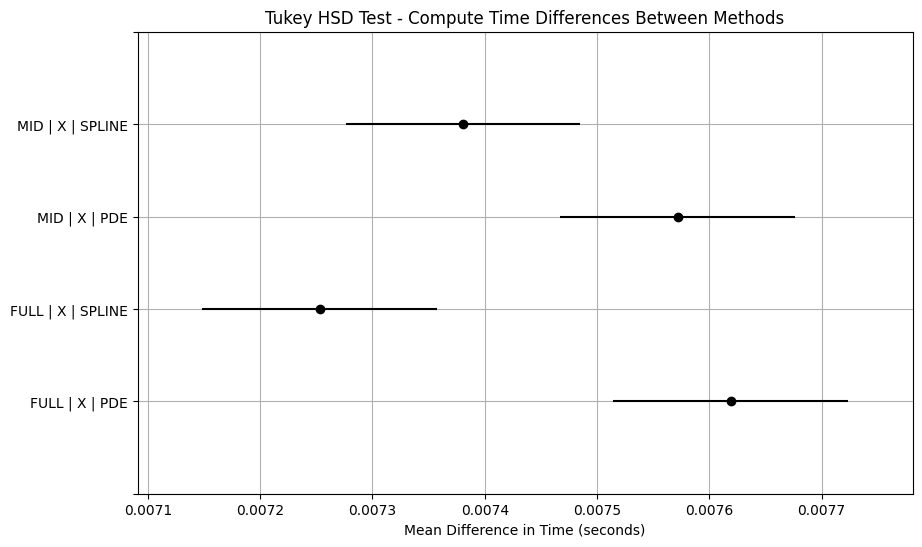

group1,group2,meandiff,p-adj,lower,upper,reject
FULL | X | PDE,FULL | X | SPLINE,-0.0004,0.0,-0.0006,-0.0002,True
FULL | X | PDE,MID | X | PDE,-0.0,0.938,-0.0003,0.0002,False
FULL | X | PDE,MID | X | SPLINE,-0.0002,0.0181,-0.0004,-0.0,True
FULL | X | SPLINE,MID | X | PDE,0.0003,0.0005,0.0001,0.0005,True
FULL | X | SPLINE,MID | X | SPLINE,0.0001,0.3965,-0.0001,0.0003,False
MID | X | PDE,MID | X | SPLINE,-0.0002,0.0876,-0.0004,0.0,False


In [134]:
# Display the Tukey HSD test results
tukey_result.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD Test - Compute Time Differences Between Methods")
plt.xlabel("Mean Difference in Time (seconds)")
plt.grid(True)
plt.show()

tukey_result.summary()

In [52]:
data = {
    "group1": [
        "FULL | X | PDE", "FULL | X | PDE", "FULL | X | PDE",
        "FULL | X | SPLINE", "FULL | X | SPLINE", "MID | X | PDE"
    ],
    "group2": [
        "FULL | X | SPLINE", "MID | X | PDE", "MID | X | SPLINE",
        "MID | X | PDE", "MID | X | SPLINE", "MID | X | SPLINE"
    ],
    "meandiff": [-0.0003, 0.0001, 0.0, 0.0004, 0.0004, -0.0001],
    "p-adj": [0.0, 0.583, 0.9669, 0.0, 0.0, 0.8521],
    "lower": [-0.0005, -0.0001, -0.0002, 0.0002, 0.0002, -0.0002],
    "upper": [-0.0002, 0.0003, 0.0002, 0.0006, 0.0006, 0.0001],
    "reject": [True, False, False, True, True, False]
}

df = pd.DataFrame(data)

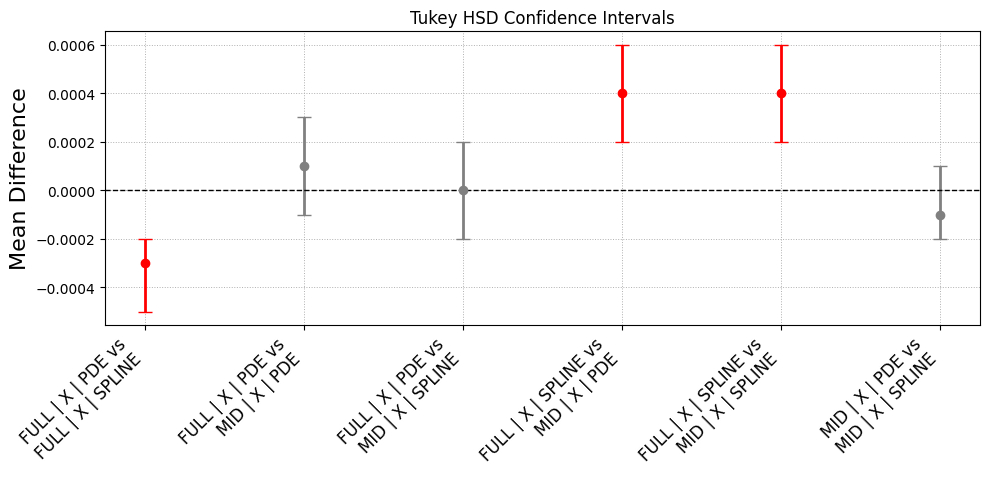

In [53]:
plt.figure(figsize=(10, 5))
x_positions = range(len(df))
colors = ['red' if rej else 'gray' for rej in df['reject']]
x_labels = [f"{g1} vs\n{g2}" for g1, g2 in zip(df['group1'], df['group2'])]

# Plot each error bar individually to allow color differentiation
for i, row in df.iterrows():
    plt.errorbar(x=i, y=row['meandiff'],
                 yerr=[[row['meandiff'] - row['lower']], [row['upper'] - row['meandiff']]],
                 fmt='o', color=colors[i], ecolor=colors[i], elinewidth=2, capsize=5)

plt.xticks(ticks=x_positions, labels=x_labels, rotation=45, ha='right', size=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Tukey HSD Confidence Intervals")
plt.ylabel("Mean Difference", fontsize = 16)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.tight_layout()
plt.show()

Interpretation:

Red points represent statistically significant differences at the 0.05 level (reject=True).

The most notable gap is between FULL | X | SPLINE and both MID | X methods, indicating that FULL | X | SPLINE performs significantly differently (better or worse, depending on context).

In [54]:
df_tukey_compute = pd.DataFrame(tukey_result.summary().data[1:], columns = tukey_result.summary().data[0])

In [55]:
df_tukey_compute

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FULL | X | PDE,FULL | X | SPLINE,-0.0004,0.0000,-0.0006,-0.0002,True
1,FULL | X | PDE,MID | X | PDE,-0.0000,0.9380,-0.0003,0.0002,False
2,FULL | X | PDE,MID | X | SPLINE,-0.0002,0.0181,-0.0004,-0.0000,True
3,FULL | X | SPLINE,MID | X | PDE,0.0003,0.0005,0.0001,0.0005,True
4,FULL | X | SPLINE,MID | X | SPLINE,0.0001,0.3965,-0.0001,0.0003,False
5,MID | X | PDE,MID | X | SPLINE,-0.0002,0.0876,-0.0004,0.0000,False


In [56]:
df_tukey_compute[df_tukey_compute['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FULL | X | PDE,FULL | X | SPLINE,-0.0004,0.0000,-0.0006,-0.0002,True
2,FULL | X | PDE,MID | X | SPLINE,-0.0002,0.0181,-0.0004,-0.0000,True
3,FULL | X | SPLINE,MID | X | PDE,0.0003,0.0005,0.0001,0.0005,True


#### Interpretation:
Significant Differences (p < 0.05) were found between:

FULL | X | PDE and FULL | X | SPLINE

FULL | X | SPLINE and MID | X | PDE

FULL | X | SPLINE and MID | X | SPLINE

No Significant Difference was observed between:

FULL | X | PDE vs MID | X | PDE

FULL | X | PDE vs MID | X | SPLINE

This suggests that the FULL | X | SPLINE method has a statistically different (lower) compute time compared to the others.

In [57]:
df_tukey_compute[df_tukey_compute['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,FULL | X | PDE,FULL | X | SPLINE,-0.0004,0.0000,-0.0006,-0.0002,True
2,FULL | X | PDE,MID | X | SPLINE,-0.0002,0.0181,-0.0004,-0.0000,True
3,FULL | X | SPLINE,MID | X | PDE,0.0003,0.0005,0.0001,0.0005,True


In [58]:
timing_stats = df_timing.groupby("Method")["Time (seconds)"].agg(["mean", "std"]).reset_index()
timing_stats.rename(columns={"mean": "MeanTime", "std": "StdTime"}, inplace=True)

In [59]:
# Attach RMSE means
rmse_means = {
    "MID | X | SPLINE": 6.8787,
    "MID | X | PDE": 6.8768,
    "FULL | X | SPLINE": 7.0040,
    "FULL | X | PDE": 6.9932,
}

In [64]:
timing_stats

,Method,MeanTime,StdTime,MeanRMSE,RMSE_Rank,Time_Rank,OverallScore,OverallRank
0,FULL | X | PDE,0.007619,0.001655,6.9932,3.0,4.0,7.0,4.0
1,FULL | X | SPLINE,0.007253,0.000682,7.0040,4.0,1.0,5.0,3.0
2,MID | X | PDE,0.007572,0.000491,6.8768,1.0,3.0,4.0,1.5
3,MID | X | SPLINE,0.007381,0.000721,6.8787,2.0,2.0,4.0,1.5
